In [49]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

In [50]:
device = 'cpu' #'mps' if torch.backends.mps.is_available() else 'cpu'

In [51]:
def drop_outliers(dataFrame):
    first_x_quartile = dataFrame['data__coordinates__x'].quantile(0.25)
    second_x_quartile = dataFrame['data__coordinates__x'].quantile(0.75)
    x_std = dataFrame['data__coordinates__x'].std()

    first_y_quartile = dataFrame['data__coordinates__y'].quantile(0.25)
    second_y_quartile = dataFrame['data__coordinates__y'].quantile(0.75)
    y_std = dataFrame['data__coordinates__y'].std()

    dropped_df = dataFrame[(dataFrame['data__coordinates__x'] < (second_x_quartile + 1.5 * x_std)) & (dataFrame['data__coordinates__x'] > (first_x_quartile - 1.5 * x_std)) ]
    dropped_df = dropped_df[(dropped_df['data__coordinates__y'] < (second_y_quartile + 1.5 * y_std)) & (dropped_df['data__coordinates__y'] > (first_y_quartile - 1.5 * y_std)) ]
    return dropped_df

In [52]:
df = pd.read_csv('data/formatted_df_Train_F10.csv')
df2 = pd.read_csv('data/formatted_df_Test_F10.csv')

df = drop_outliers(df)
df2 = drop_outliers(df2)

dfTest = df2.sample(frac=0.9)
dfValid = df2.drop(dfTest.index)

In [53]:
class Data(Dataset):
    def __init__(self,dataframe):
        x = dataframe.iloc[:,:24].values
        y = dataframe.iloc[:,24:26].values
        self.len = dataframe.shape[0]

        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

    def __len__(self):
        return self.len

In [54]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(24,50)
        self.l2 = nn.Linear(50,30)
        self.l3 = nn.Linear(30,20)
        self.l4 = nn.Linear(20,15)
        self.l5 = nn.Linear(15,10)
        self.l6 = nn.Linear(10,2)
    def forward(self,x):
        y_pred = F.selu(self.l1(x))
        y_pred = F.selu(self.l2(y_pred))
        y_pred = F.selu(self.l3(y_pred))
        y_pred = F.selu(self.l4(y_pred))
        y_pred = F.selu(self.l5(y_pred))
        y_pred = self.l6(y_pred)

        return  y_pred

In [55]:
model = Model()
model.to(device)
train_dataset = Data(df)
valid_dataset = Data(dfValid)
train_loader = DataLoader(dataset=train_dataset,batch_size=80,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,batch_size=200)

In [56]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
criterion = nn.MSELoss()

In [57]:
epochs = 60
min_loss = np.inf

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for i,(x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        y_result = model(x)
        loss = criterion(y_result, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for x,y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            y_result = model(x)
            loss = criterion(y_result, y)
            valid_loss += loss

    valid_loss /= len(valid_loader)
    train_loss /= len(train_loader)
    print(f"Epoch = {epoch + 1}\tTrain loss = {train_loss}\tValid loss = {valid_loss}")
    if valid_loss < min_loss:
        print(f"Loss decreased by {min_loss - valid_loss}")
        min_loss = valid_loss
        torch.save(model, "testing_training_F10/models/model_test3.pth")

Epoch = 1	Train loss = 11384286.0	Valid loss = 12163215.0
Loss decreased by inf
Epoch = 2	Train loss = 11204268.0	Valid loss = 11805380.0
Loss decreased by 357835.0
Epoch = 3	Train loss = 10499564.0	Valid loss = 10611601.0
Loss decreased by 1193779.0
Epoch = 4	Train loss = 8836623.0	Valid loss = 8319914.0
Loss decreased by 2291687.0
Epoch = 5	Train loss = 6149543.5	Valid loss = 5286587.0
Loss decreased by 3033327.0
Epoch = 6	Train loss = 3408196.0	Valid loss = 2963476.0
Loss decreased by 2323111.0
Epoch = 7	Train loss = 1781934.5	Valid loss = 1881744.75
Loss decreased by 1081731.25
Epoch = 8	Train loss = 1139339.25	Valid loss = 1392326.75
Loss decreased by 489418.0
Epoch = 9	Train loss = 846871.4375	Valid loss = 1091464.125
Loss decreased by 300862.625
Epoch = 10	Train loss = 679373.4375	Valid loss = 895598.1875
Loss decreased by 195865.9375
Epoch = 11	Train loss = 586228.5625	Valid loss = 773464.5
Loss decreased by 122133.6875
Epoch = 12	Train loss = 540676.5625	Valid loss = 705412.31

In [58]:
# model = torch.load('testing_training_F10/models/model_test3.pth')

In [59]:
test_F10 = dfTest.iloc[:,:24].values
test_F10 = torch.tensor(test_F10,dtype=torch.float32,device=device)
test_F10_cords = dfTest.iloc[:,22:24].values
test_F10_cords = torch.tensor(test_F10_cords,dtype=torch.float32,device=device)

In [60]:
predictions = model(test_F10)
predictions_transposed = torch.transpose(predictions,0,1)
predictions_numpy = predictions_transposed.cpu().data.numpy()

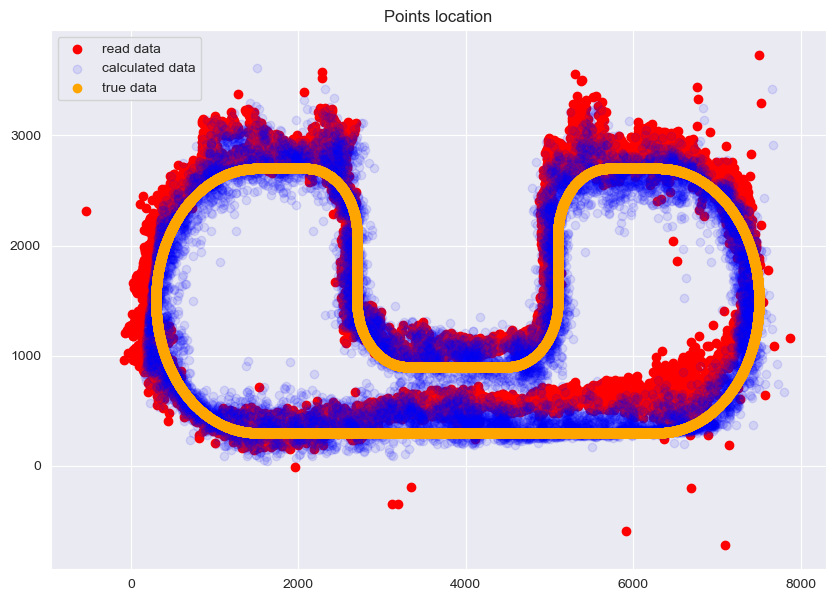

In [76]:
plt.figure(figsize=(10, 7))
plt.scatter(x=dfTest.data__coordinates__x,y=dfTest.data__coordinates__y,c='r',label="read data")
plt.scatter(x=predictions_numpy[0],y=predictions_numpy[1],c='b',alpha=0.1,label='calculated data')
plt.scatter(x=dfTest.reference__x,y=dfTest.reference__y,c='orange',label='true data')
plt.legend(loc="upper left")
plt.title("Points location")
plt.show()

In [62]:
test_F10_y = dfTest.iloc[:,24:26].values
test_F10_y = torch.tensor(test_F10_y,dtype=torch.float32,device=device)

In [63]:
error_without_neural = torch.empty((test_F10_y.size()[0]),dtype=torch.float32,device=device)
error_after_neural = torch.empty((test_F10_y.size()[0]),dtype=torch.float32,device=device)

In [64]:
for i,to in enumerate(test_F10_y):
    error_without_neural[i] = criterion(to,test_F10_cords[i])
    error_after_neural[i] = criterion(to,predictions[i])

In [65]:
error_without_neural_out = error_without_neural.cpu().data.numpy()
error_after_neural_out = error_after_neural.cpu().data.numpy()

In [66]:
error_without_neural_out = (error_without_neural_out * 2)
error_without_neural_out = np.sqrt(error_without_neural_out)
error_after_neural_out = (error_after_neural_out * 2)
error_after_neural_out = np.sqrt(error_after_neural_out)

In [67]:
help_df_1 = pd.DataFrame(columns=['Error',"After neural network"])
help_df_1['Error'] = error_after_neural_out
help_df_1['After neural network'] = True

In [68]:
help_df_2 = pd.DataFrame(columns=['Error', "After neural network"])
help_df_2['Error'] = error_without_neural_out
help_df_2['After neural network'] = False

In [69]:
help_df = pd.concat([help_df_2,help_df_1])

<Figure size 1000x700 with 0 Axes>

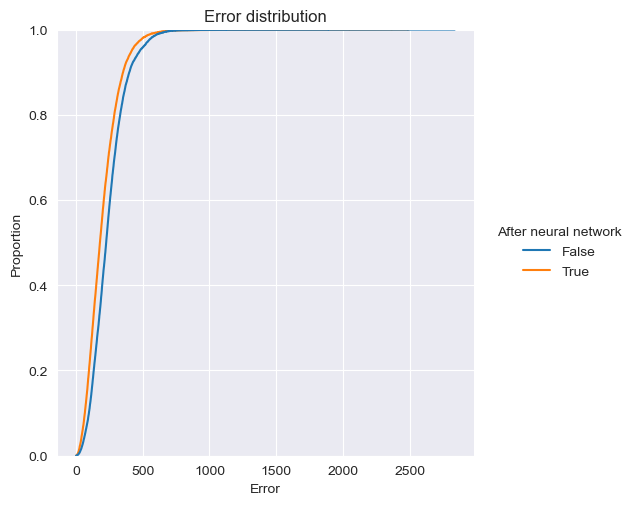

In [75]:
plt.figure(figsize=(10, 7))
sns.displot(data=help_df,x="Error",kind='ecdf',hue="After neural network")
plt.title('Error distribution')
plt.show()